# Solucion de la tarea 3
## Módulo 4 - Big Data
## Estudidante: Yoksan Varela Cambronero

In [1]:
# Librerias generales
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Informacion del set de datos, carga y explicacion de los atributos

En esta tarea se plantea una solucion con aprendizaje automatico con la cual se plantea predecir si un animal de un refugio va a ser adoptado o no.

El set de datos a utilizar se llama pet_adoption_data.csv del post *Predict Pet Adoption Status Dataset* (URL: https://www.kaggle.com/datasets/rabieelkharoua/predict-pet-adoption-status-dataset). A continuacion de procede a cargar el CSV en un dataframe explicar las columnas del mismo.

In [2]:
# Cargar el conjunto de datos completo. Este paso no realiza ningún ajuste; simplemente lectura
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType, BooleanType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

df_pets_raw = spark \
    .read \
    .format("csv") \
    .option("path", "./datasets/pet_adoption_data.csv") \
    .option("header", False) \
    .schema(StructType([
                StructField("pet_id", IntegerType()),           # El ID del animal
                StructField("pet_type", StringType()),          # El tipo del animal
                StructField("breed", StringType()),             # La raza del mismo
                StructField("age_months", IntegerType()),       # Edad del animal en meses
                StructField("color", StringType()),             # Color del animal
                StructField("size", StringType()),              # Tamanno del mismo
                StructField("weight_kg", FloatType()),          # Masa del animal en kilogramos
                StructField("vaccinated", StringType()),       # Indicador si el animal ha sido vacunado o no
                StructField("health_condition", StringType()), # Indicador si es saludable o tiene algun problema de salud
                StructField("days_in_shelter", IntegerType()),  # Cantidad de dias que el animal ha estado en el refugio
                StructField("adoption_fee", IntegerType()),     # Cantidad dolares a pagar por el animal
                StructField("previous_owner", StringType()),   # Indicador si el animal tuvo un dueno antes o no
                StructField("adoption_status", StringType())])).load() # Indicador si el animal fue adoptado o no

df_pets_raw.printSchema()
df_pets_raw.show()

ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/09 22:47:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


root
 |-- pet_id: integer (nullable = true)
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: string (nullable = true)
 |-- health_condition: string (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: string (nullable = true)
 |-- adoption_status: string (nullable = true)

+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|           breed|age_months| color|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+----

In [3]:
from pyspark.sql.functions import col, when

# Convirtiendo los atributos binarios a BooleanType
# vaccinated
df_pets_transformed = df_pets_raw.withColumn('vaccinated', when(col('vaccinated') == "1", True).when(col('vaccinated') == "0", False).otherwise(None))
df_pets_transformed = df_pets_raw.withColumn('vaccinated', col('vaccinated').cast(BooleanType()))

# health_condition
df_pets_transformed = df_pets_transformed.withColumn('health_condition', when(col('health_condition') == "1", True).when(col('health_condition') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('health_condition', col('health_condition').cast(BooleanType()))

# previous_owner
df_pets_transformed = df_pets_transformed.withColumn('previous_owner', when(col('previous_owner') == "1", True).when(col('previous_owner') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('previous_owner', col('previous_owner').cast(BooleanType()))

# adoption_status
df_pets_transformed = df_pets_transformed.withColumn('adoption_status', when(col('adoption_status') == "1", True).when(col('adoption_status') == "0", False).otherwise(None))
df_pets_transformed = df_pets_transformed.withColumn('adoption_status', col('adoption_status').cast(BooleanType()))

df_pets_transformed.printSchema()
df_pets_transformed.show()


root
 |-- pet_id: integer (nullable = true)
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: boolean (nullable = true)
 |-- health_condition: boolean (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: boolean (nullable = true)
 |-- adoption_status: boolean (nullable = true)

+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|           breed|age_months| color|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+----------------+----------+------+------+---------+----------+----------------+---------------+------------+

**La variable predictiva en este ejercicio es adoption_status**, el cual es 1 si el animal fue adoptado o 0 en el caso contrario. Revisando la presencia de valores NaN en el dataset:

In [4]:
from pyspark.sql.functions import col, sum

nan_counts = df_pets_transformed.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_pets_raw.columns])
nan_counts.show()

+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_id|pet_type|breed|age_months|color|size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+
|     0|       0|    0|         0|    0|   0|        0|         0|               0|              0|           0|             0|              0|
+------+--------+-----+----------+-----+----+---------+----------+----------------+---------------+------------+--------------+---------------+



Se concluye que no hay NaN en el dataset. Se descartan las siguientes columnas:
- **pet_id:** Al ser un indicador unico del animal, no aporta ningun valor al estudio.
- **color:** El color es una variable completamente subjetiva por parte de las personas, asi que podria introducir ruido al estudio.

In [5]:
df_pets_clean = df_pets_transformed.drop('pet_id','color')
df_pets_clean.printSchema()
df_pets_clean.show()

root
 |-- pet_type: string (nullable = true)
 |-- breed: string (nullable = true)
 |-- age_months: integer (nullable = true)
 |-- size: string (nullable = true)
 |-- weight_kg: float (nullable = true)
 |-- vaccinated: boolean (nullable = true)
 |-- health_condition: boolean (nullable = true)
 |-- days_in_shelter: integer (nullable = true)
 |-- adoption_fee: integer (nullable = true)
 |-- previous_owner: boolean (nullable = true)
 |-- adoption_status: boolean (nullable = true)

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|    Bird|        Parakeet|       131| Large|5.0397677|      true|           false|   

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


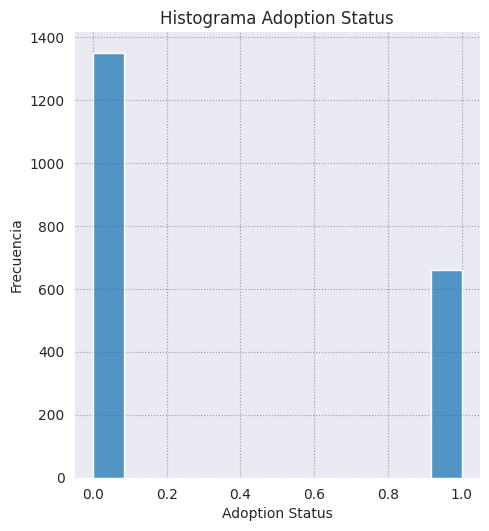

In [6]:
# Analizando el balanceo en el objetivo predictivo
# Estilo de Seaborn
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Hacer collect de la variable predictiva
df_adopt_status = df_pets_clean.select('adoption_status').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_adopt_status, kde=False)
plt.xlabel('Adoption Status')
plt.ylabel('Frecuencia')
plt.title('Histograma Adoption Status')
plt.show()


In [7]:
# Solucionando el problema de balanceo con un sub-sampleo de las mascotas adoptadas
# Haciendo una cuenta de los valores de adoption_status
class_counts = df_pets_clean.groupBy('adoption_status').count()
class_counts.show()

+---------------+-----+
|adoption_status|count|
+---------------+-----+
|           true|  659|
|          false| 1348|
+---------------+-----+



Hay un problema de balance, en donde hay mas del doble de animales NO adoptados contra los adoptados. Se procede a hacer un balance con un sub-sampleo de los animales adoptados:

In [8]:
# Separando los dos valores
minority_class_df = df_pets_clean.filter(col('adoption_status') == True)
majority_class_df = df_pets_clean.filter(col('adoption_status') == False)

# Calculando la cantidad de subsampleo necesario para que haya balance
min_count = class_counts.agg({"count": "min"}).collect()[0][0]
fraction = min_count / majority_class_df.count()

# Creando un dataframe con el sub-sampleo
undersampled_majority_class_df = majority_class_df.sample(withReplacement=False, fraction=fraction)

# Ahora se combinan los dataframe para generar uno ya balanceado
df_pets_balanced = undersampled_majority_class_df.union(minority_class_df)

df_pets_balanced.groupBy('adoption_status').count().show()

+---------------+-----+
|adoption_status|count|
+---------------+-----+
|          false|  654|
|           true|  659|
+---------------+-----+



<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


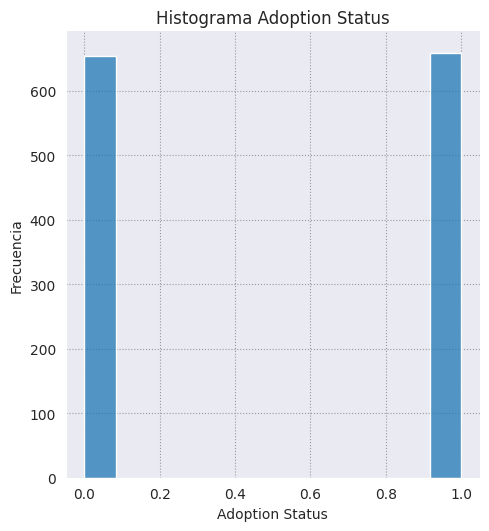

In [9]:
# Se comprueba el resultados final de forma visual
df_adopt_status_balanced = df_pets_balanced.select('adoption_status').rdd.flatMap(lambda x: x).collect()

sns.displot(data=df_adopt_status_balanced, kde=False)
plt.xlabel('Adoption Status')
plt.ylabel('Frecuencia')
plt.title('Histograma Adoption Status')
plt.show()

Ya se cuenta con un set de datos balanceado, a costas de haber perdido los datos. Ahora se procede a analizar los otros atributos con respecto al objectivo predictivo:

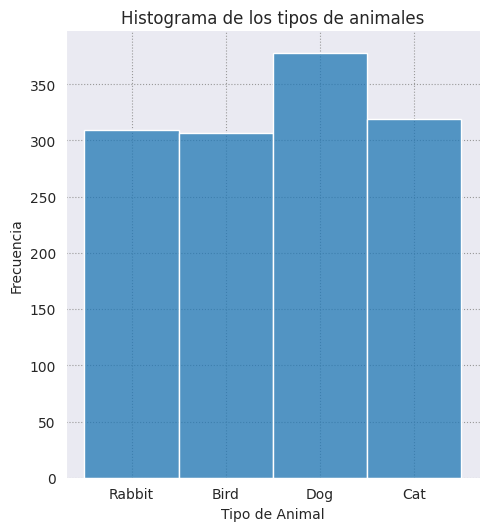

In [10]:
# Tipos de mascotas
petType_data = df_pets_balanced.select('pet_type').rdd.flatMap(lambda x: x).collect()

sns.displot(data=petType_data, kde= False)
plt.xlabel('Tipo de Animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de los tipos de animales')
plt.show()

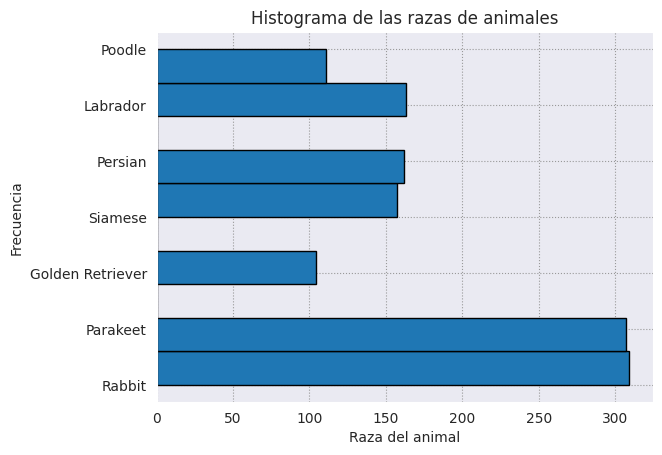

In [11]:
# Razas de los animales
breed_data = df_pets_balanced.select('breed').rdd.flatMap(lambda x: x).collect()

plt.hist(breed_data, orientation='horizontal', edgecolor='black')
plt.xlabel('Raza del animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de las razas de animales')
plt.show()

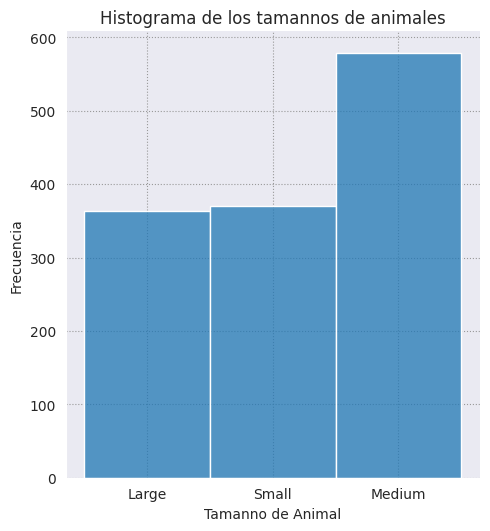

In [12]:
# Tamanno de los animales
size_data = df_pets_balanced.select('size').rdd.flatMap(lambda x: x).collect()

sns.displot(data=size_data, kde= False)
plt.xlabel('Tamanno de Animal')
plt.ylabel('Frecuencia')
plt.title('Histograma de los tamannos de animales')
plt.show()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


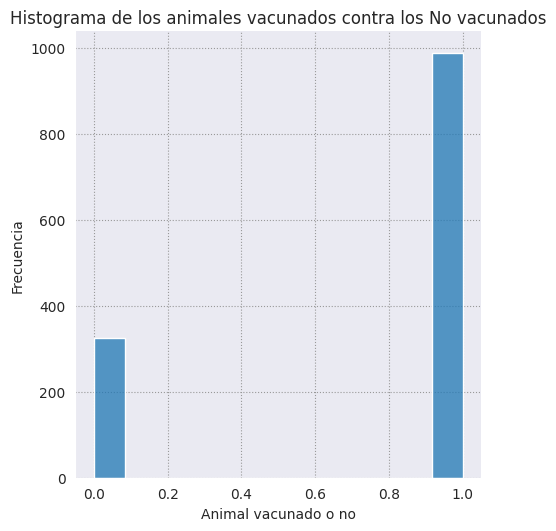

In [13]:
# Vacunados o no?
vaccinated_data = df_pets_balanced.select('vaccinated').rdd.flatMap(lambda x: x).collect()

sns.displot(data=vaccinated_data, kde= False)
plt.xlabel('Animal vacunado o no')
plt.ylabel('Frecuencia')
plt.title('Histograma de los animales vacunados contra los No vacunados')
plt.show()

In [14]:
# Algunas otras metricas estadisticas descriptivas
df_pets_balanced.describe(['weight_kg', 'days_in_shelter', 'adoption_fee']).show()

+-------+------------------+------------------+------------------+
|summary|         weight_kg|   days_in_shelter|      adoption_fee|
+-------+------------------+------------------+------------------+
|  count|              1313|              1313|              1313|
|   mean|15.814267601934173| 43.85072353389185|250.45392231530846|
| stddev|  8.39951196160519|25.784974203482744| 142.0723081698341|
|    min|          1.018198|                 1|                 0|
|    max|         29.995628|                89|               499|
+-------+------------------+------------------+------------------+



Con este analsis, se observa que el set de datos esta bastante saludable. Hay un problema de balance entre los animales vacunados contra los no vacunados, pero el resto de variables categorias se muestran mejor balanceadas, por lo tanto, no se van a eliminar mas datos.

Ahora se procede a almacenar esto en la base de datos:

In [15]:
# Almacenar el conjunto de datos limpio en la base de datos
df_pets_balanced \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_raw") \
    .save()

### Carga de los datos desde la base de datos y pre-procesado antes de entrenar los modelos de aprendizaje automatico

Se cargan los datos de la base de datos para empezar con el pre-procesado, analisis de correlacion y almacenaje.

In [16]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3_raw") \
    .load()

df.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+
|  Rabbit|          Rabbit|        73| Large|16.086727|     false|           false|              8|         235|         false|          false|
|    Bird|        Parakeet|        97| Small|3.3394232|     false|           false|             61|         217|          true|          false|
|    Bird|        Parakeet|        49|Medium|24.597597|      true|            true|             69|         405|         false|          false|
|    Bird|        Parakeet|        60| Large| 7.295994|     false|           false|             73|         231|          true|         

In [17]:
# Indexado de los atributos string
from pyspark.ml.feature import StringIndexer

indexer_pet_type = StringIndexer(inputCol='pet_type', outputCol='pet_type_indexed')
df_indexed = indexer_pet_type.fit(df).transform(df)

indexer_breed = StringIndexer(inputCol='breed', outputCol='breed_indexed')
df_indexed = indexer_breed.fit(df_indexed).transform(df_indexed)

indexer_size = StringIndexer(inputCol='size', outputCol='size_indexed')
df_indexed = indexer_size.fit(df_indexed).transform(df_indexed)

df_indexed.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|pet_type_indexed|breed_indexed|size_indexed|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+
|  Rabbit|          Rabbit|        73| Large|16.086727|     false|           false|              8|         235|         false|          false|             2.0|          0.0|         2.0|
|    Bird|        Parakeet|        97| Small|3.3394232|     false|           false|             61|         217|          true|          false|             3.0|          1.0|         1.0|
|    Bird|        Parakeet|        49|Medium|24.597597|     

In [18]:
# Haciendo un One Hot Encoding the las columnas indexadas
from pyspark.ml.feature import OneHotEncoder

encoder_pettype = OneHotEncoder(inputCol="pet_type_indexed", outputCol="pet_type_vector")
df_encoded = encoder_pettype.fit(df_indexed).transform(df_indexed)

encoder_breed = OneHotEncoder(inputCol="breed_indexed", outputCol="breed_vector")
df_encoded = encoder_breed.fit(df_encoded).transform(df_encoded)

encoder_size = OneHotEncoder(inputCol="size_indexed", outputCol="size_vector")
df_encoded = encoder_size.fit(df_encoded).transform(df_encoded)

df_encoded.show()

+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+---------------+-------------+-------------+
|pet_type|           breed|age_months|  size|weight_kg|vaccinated|health_condition|days_in_shelter|adoption_fee|previous_owner|adoption_status|pet_type_indexed|breed_indexed|size_indexed|pet_type_vector| breed_vector|  size_vector|
+--------+----------------+----------+------+---------+----------+----------------+---------------+------------+--------------+---------------+----------------+-------------+------------+---------------+-------------+-------------+
|  Rabbit|          Rabbit|        73| Large|16.086727|     false|           false|              8|         235|         false|          false|             2.0|          0.0|         2.0|  (3,[2],[1.0])|(6,[0],[1.0])|    (2,[],[])|
|    Bird|        Parakeet|        97| Small|3.3394232|     false|      

In [19]:
# Ensamblando el vector de features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['pet_type_vector', 
                                       'breed_vector', 
                                       'age_months',
                                       'size_vector', 
                                       'weight_kg', 
                                       'vaccinated', 
                                       'health_condition', 
                                       'days_in_shelter', 
                                       'adoption_fee', 
                                       'previous_owner'], outputCol='features_not_scaled')
df_assembled = assembler.transform(df_encoded)
df_pets_data = df_assembled.select('features_not_scaled', 'adoption_status')
df_pets_data.show()


+--------------------+---------------+
| features_not_scaled|adoption_status|
+--------------------+---------------+
|(18,[2,3,9,12,15,...|          false|
|(18,[4,9,11,12,15...|          false|
|(18,[4,9,10,12,13...|          false|
|(18,[4,9,12,15,16...|          false|
|(18,[0,9,12,13,15...|          false|
|(18,[1,7,9,12,13,...|          false|
|(18,[2,3,9,11,12,...|          false|
|(18,[1,6,9,11,12,...|          false|
|(18,[0,5,9,11,12,...|          false|
|(18,[2,3,9,11,12,...|          false|
|(18,[0,9,11,12,13...|          false|
|(18,[4,9,12,13,15...|          false|
|(18,[2,3,9,12,13,...|          false|
|(18,[2,3,9,10,12,...|          false|
|(18,[1,7,9,12,13,...|           true|
|(18,[2,3,9,12,14,...|          false|
|(18,[4,9,11,12,13...|          false|
|(18,[4,9,12,15,16...|          false|
|(18,[0,9,10,12,15...|          false|
|(18,[0,8,9,12,13,...|          false|
+--------------------+---------------+
only showing top 20 rows



In [20]:
# Renombrando adoption_status a label, lo cual es compatible con funciones a usar mas adelante
df_pets_data = df_pets_data.withColumnRenamed('adoption_status', 'label')
df_pets_data.show()

+--------------------+-----+
| features_not_scaled|label|
+--------------------+-----+
|(18,[2,3,9,12,15,...|false|
|(18,[4,9,11,12,15...|false|
|(18,[4,9,10,12,13...|false|
|(18,[4,9,12,15,16...|false|
|(18,[0,9,12,13,15...|false|
|(18,[1,7,9,12,13,...|false|
|(18,[2,3,9,11,12,...|false|
|(18,[1,6,9,11,12,...|false|
|(18,[0,5,9,11,12,...|false|
|(18,[2,3,9,11,12,...|false|
|(18,[0,9,11,12,13...|false|
|(18,[4,9,12,13,15...|false|
|(18,[2,3,9,12,13,...|false|
|(18,[2,3,9,10,12,...|false|
|(18,[1,7,9,12,13,...| true|
|(18,[2,3,9,12,14,...|false|
|(18,[4,9,11,12,13...|false|
|(18,[4,9,12,15,16...|false|
|(18,[0,9,10,12,15...|false|
|(18,[0,8,9,12,13,...|false|
+--------------------+-----+
only showing top 20 rows



In [21]:
# Normalizando los atributos para tener todos los features en la misma escala
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_not_scaled", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_pets_data)
df_pets_data_normalized = scaler_model.transform(df_pets_data)
df_pets_data_normalized.show()

+--------------------+-----+--------------------+
| features_not_scaled|label|            features|
+--------------------+-----+--------------------+
|(18,[2,3,9,12,15,...|false|[-0.6355864778082...|
|(18,[4,9,11,12,15...|false|[-0.6355864778082...|
|(18,[4,9,10,12,13...|false|[-0.6355864778082...|
|(18,[4,9,12,15,16...|false|[-0.6355864778082...|
|(18,[0,9,12,13,15...|false|[1.57215173743582...|
|(18,[1,7,9,12,13,...|false|[-0.6355864778082...|
|(18,[2,3,9,11,12,...|false|[-0.6355864778082...|
|(18,[1,6,9,11,12,...|false|[-0.6355864778082...|
|(18,[0,5,9,11,12,...|false|[1.57215173743582...|
|(18,[2,3,9,11,12,...|false|[-0.6355864778082...|
|(18,[0,9,11,12,13...|false|[1.57215173743582...|
|(18,[4,9,12,13,15...|false|[-0.6355864778082...|
|(18,[2,3,9,12,13,...|false|[-0.6355864778082...|
|(18,[2,3,9,10,12,...|false|[-0.6355864778082...|
|(18,[1,7,9,12,13,...| true|[-0.6355864778082...|
|(18,[2,3,9,12,14,...|false|[-0.6355864778082...|
|(18,[4,9,11,12,13...|false|[-0.6355864778082...|


24/07/09 22:47:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<AxesSubplot:>

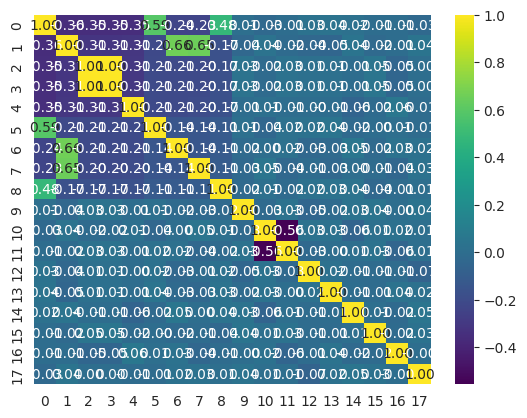

In [22]:
# Calculando las correlaciones para ver si hay atributos correlacionados
from pyspark.ml.stat import Correlation

pearson_matrix = Correlation.corr(df_pets_data_normalized, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

Aunque es dificil de leer por completo, se puede ver que los casos mas graves tienen una correlacion de alrededor de 0.6, lo cual es aceptable y se concluye que el set de datos esta listo para usarse para entrenar y probar un aprendizaje automatico. Antes de eso, se almacenan los datos en la base de datos:

In [23]:
# Primero, descomponer los features en columnas aparte por medio de una funcion que haga split
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType

def to_array(v):
    return v.toArray().tolist()

to_array_udf = udf(to_array, ArrayType(FloatType()))

# Se aplica la funcion anterior a la columna con los features normalizados
df_array = df_pets_data_normalized.withColumn("features_array", to_array_udf("features"))
df_features = df_array.select('features_array', 'label')

# Se crean columnas para cada feature
num_features = len(df_features.select("features_array").first()[0])
for i in range(num_features):
    df_features = df_features.withColumn(f"feature_{i}", df_features["features_array"].getItem(i))

# Se crea un dataframe donde se descarten los features en vectores
df_pets_reconstructed = df_features.select('label', *[f"feature_{i}" for i in range(num_features)])
df_pets_reconstructed.show()


+-----+----------+-----------+---------+---------+----------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+
|label| feature_0|  feature_1|feature_2|feature_3| feature_4|  feature_5|  feature_6|feature_7|  feature_8|  feature_9|feature_10|feature_11| feature_12|feature_13| feature_14| feature_15| feature_16| feature_17|
+-----+----------+-----------+---------+---------+----------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+
|false|-0.6355865|-0.56628716|1.8018646|1.8018646|-0.5522106|-0.37633917|-0.37501997|-0.368388|-0.30376926|-0.28435758|-0.8878218|-0.6261517|0.032437544|-1.7464663|-0.44110563| -1.3903726|-0.10877505|-0.64385927|
|false|-0.6355865|-0.56628716|-0.554558|-0.554558|  1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| 0.16213582|-0.8878218| 1.5958407| -1.485

In [24]:
# Ya con el set de datos reconstruido, se almacena en la base de datos
df_pets_reconstructed \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

### Carga de los datos desde la base de datos, y desarrollo del aprendizaje automatico

Se cargan los datos de la base de datos para vectorizar los datos y desarrollar los dos modelos de aprendizaje automatico:

In [25]:
# Cargar el conjunto de datos. Esta vez desde la base de datos
df_pets_segmented = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df_pets_segmented.show()

+-----+----------+-----------+---------+---------+----------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+
|label| feature_0|  feature_1|feature_2|feature_3| feature_4|  feature_5|  feature_6|feature_7|  feature_8|  feature_9|feature_10|feature_11| feature_12|feature_13| feature_14| feature_15| feature_16| feature_17|
+-----+----------+-----------+---------+---------+----------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+
|false|-0.6355865|-0.56628716|1.8018646|1.8018646|-0.5522106|-0.37633917|-0.37501997|-0.368388|-0.30376926|-0.28435758|-0.8878218|-0.6261517|0.032437544|-1.7464663|-0.44110563| -1.3903726|-0.10877505|-0.64385927|
|false|-0.6355865|-0.56628716|-0.554558|-0.554558|  1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| 0.16213582|-0.8878218| 1.5958407| -1.485

In [26]:
# Volviendo a generar los vectores de los atributos (recordar que en este ejercicio son 18 atributos)
num_features = 18
feature_columns = [f"feature_{i}" for i in range(num_features)]
assembler_final = VectorAssembler(inputCols=feature_columns, outputCol="features")

df_pets_loaded = assembler_final.transform(df_pets_segmented)

df_pets_loaded = df_pets_loaded.select('features','label')
df_pets_loaded.printSchema()
df_pets_loaded.show()


root
 |-- features: vector (nullable = true)
 |-- label: boolean (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[1.57215178012847...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[1.57215178012847...|false|
|[-0.6355865001678...|false|
|[1.57215178012847...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...| true|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[-0.6355865001678...|false|
|[1.57215178012847...|false|
|[1.57215178012847...|false|
+--------------------+-----+
only showing top 20 rows



24/07/09 22:47:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [27]:
# Convirtiendo la columna label a integer
df_pets_ready = df_pets_loaded.withColumn('label', col('label').cast("integer"))
df_pets_ready.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[1.57215178012847...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[1.57215178012847...|    0|
|[-0.6355865001678...|    0|
|[1.57215178012847...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[1.57215178012847...|    0|
|[1.57215178012847...|    0|
+--------------------+-----+
only showing top 20 rows



In [28]:
# Antes de empezar con los modelos, se hace un split de 80/20 para prueba y entrenamiento
train_df, test_df = df_pets_ready.randomSplit([0.8, 0.2], seed=12345)

print('Train dataset:')
train_df.show()
print('Test dataset:')
test_df.show()

Train dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
+--------------------+-----+
only showing top 20 rows

Test dataset:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.6355865001678...|    1|
|[-0.6355865001678...|    0|
|[-0.635586500167

### Primer modelo a probar: Support Vector Machine
Como primer modelo se prueba el SVM, dado que esta optimizado para problemas de categorizacion binaria

In [29]:
# Creando en modelo SVM
from pyspark.ml.classification import LinearSVC

svm_model = LinearSVC(featuresCol='features', labelCol='label')

In [30]:
# Creando el protocolo k-fold con el optimizador de hyperparametros
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Optimizador de hyperparametros
paramGrid = ParamGridBuilder() \
    .addGrid(svm_model.maxIter, [10, 20]) \
    .addGrid(svm_model.regParam, [0.1, 0.01]) \
    .build()

# Protocolo k-fold de 5
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=svm_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [31]:
# Corriendo la validacion cruzada
svm_cvModel = crossval.fit(train_df)

In [32]:
# Haciendo una prediccion y evaluando el Accuracy
svm_predictions = svm_cvModel.transform(test_df)

accuracy = evaluator.evaluate(svm_predictions)
print(f"SVM accuracy = {accuracy}")

SVM accuracy = 0.8828451882845189


In [33]:
svm_predictions.show()

+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[-0.6355865001678...|    1|[-0.8589648138018...|       1.0|
|[-0.6355865001678...|    1|[-0.0420063921928...|       1.0|
|[-0.6355865001678...|    0|[1.42225505063107...|       0.0|
|[-0.6355865001678...|    1|[-2.6589636867852...|       1.0|
|[-0.6355865001678...|    0|[1.84134322734870...|       0.0|
|[-0.6355865001678...|    1|[-0.2797270765053...|       1.0|
|[-0.6355865001678...|    1|[-0.2224464048551...|       1.0|
|[-0.6355865001678...|    0|[-0.1441113310807...|       1.0|
|[-0.6355865001678...|    0|[-0.1485331857463...|       1.0|
|[-0.6355865001678...|    0|[4.51703457134055...|       0.0|
|[-0.6355865001678...|    1|[-2.3240163269911...|       1.0|
|[-0.6355865001678...|    0|[2.59261780422613...|       0.0|
|[-0.6355865001678...|    1|[-2.4942600590921...|       1.0|
|[-0.6355865001678...|  

In [34]:
# Union de la columna de la prediccion con el set de datos cargados de la base de datos
svm_predictions_nolabel = svm_predictions.drop('label')
df_pets_joint_svm = test_df.join(svm_predictions_nolabel, on='features', how='left')
df_pets_joint_svm.show()

+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|[-0.6355865001678...|    1|[-0.8589648138018...|       1.0|
|[-0.6355865001678...|    1|[-0.0420063921928...|       1.0|
|[-0.6355865001678...|    0|[1.42225505063107...|       0.0|
|[-0.6355865001678...|    1|[-2.6589636867852...|       1.0|
|[-0.6355865001678...|    0|[1.84134322734870...|       0.0|
|[-0.6355865001678...|    1|[-0.2797270765053...|       1.0|
|[-0.6355865001678...|    1|[-0.2224464048551...|       1.0|
|[-0.6355865001678...|    0|[-0.1441113310807...|       1.0|
|[-0.6355865001678...|    0|[-0.1485331857463...|       1.0|
|[-0.6355865001678...|    0|[4.51703457134055...|       0.0|
|[-0.6355865001678...|    1|[-2.3240163269911...|       1.0|
|[-0.6355865001678...|    0|[2.59261780422613...|       0.0|
|[-0.6355865001678...|    1|[-2.4942600590921...|       1.0|
|[-0.6355865001678...|  

In [35]:
# Creando un dataframe expandido del test con la prediccion para poder almacenarlo en la base de datos
df_test_array = df_pets_joint_svm.withColumn("features_array", to_array_udf("features"))
df_test_features = df_test_array.select('features_array', 'label', 'prediction')

# Se crean columnas para cada feature
num_features = len(df_test_features.select("features_array").first()[0])
for i in range(num_features):
    df_test_features = df_test_features.withColumn(f"feature_{i}", df_test_features["features_array"].getItem(i))

# Se crea un dataframe donde se descarten los features en vectores
df_test_for_prediction_svm = df_test_features.select(*[f"feature_{i}" for i in range(num_features)], 'label', 'prediction')
df_test_for_prediction_svm.show()

+----------+-----------+---------+---------+---------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+-----+----------+
| feature_0|  feature_1|feature_2|feature_3|feature_4|  feature_5|  feature_6|feature_7|  feature_8|  feature_9|feature_10|feature_11| feature_12|feature_13| feature_14| feature_15| feature_16| feature_17|label|prediction|
+----------+-----------+---------+---------+---------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+-----+----------+
|-0.6355865|-0.56628716|-0.554558|-0.554558| 1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| -1.6052339| 1.1254944|-0.6261517| 0.33129624| 0.5721487|   2.265304| -1.5067195|  1.5734669|  1.5519516|    1|       1.0|
|-0.6355865|-0.56628716|-0.554558|-0.554558| 1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| -1.4191

In [36]:
# Almacenando el set datos en la base de datos
df_test_for_prediction_svm \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1") \
    .save()

### Segundo modelo a probar: Random Forest
Como primer modelo se prueba el SVM, dado que esta optimizado para problemas de categorizacion binaria

In [37]:
# Creando el modelo Random Forest
from pyspark.ml.classification import RandomForestClassifier

rf_model = RandomForestClassifier(featuresCol='features', labelCol='label')

In [38]:
# Set up the parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [5, 20]) \
    .addGrid(rf_model.maxDepth, [2, 10]) \
    .build()

# Protocolo k-fold de 5
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

In [39]:
# Corriendo la validacion cruzada
rf_cvModel = crossval.fit(train_df)

In [40]:
# Haciendo una prediccion y evaluando el Accuracy
rf_predictions = rf_cvModel.transform(test_df)

accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest accuracy = {accuracy}")

Random Forest accuracy = 0.895397489539749


In [41]:
rf_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.6355865001678...|    1|[6.45467029849052...|[0.32273351492452...|       1.0|
|[-0.6355865001678...|    1|          [6.0,14.0]|           [0.3,0.7]|       1.0|
|[-0.6355865001678...|    0|[11.8538306451612...|[0.59269153225806...|       0.0|
|[-0.6355865001678...|    1|[0.26058432080680...|[0.01302921604034...|       1.0|
|[-0.6355865001678...|    0|[14.8478331704138...|[0.74239165852069...|       0.0|
|[-0.6355865001678...|    1|[3.77727272727272...|[0.18886363636363...|       1.0|
|[-0.6355865001678...|    1|[3.40965896062204...|[0.17048294803110...|       1.0|
|[-0.6355865001678...|    0|[17.5826814949222...|[0.87913407474611...|       0.0|
|[-0.6355865001678...|    0|[17.1196086289190...|[0.85598043144595...|       0.0|
|[-0.63558650016

In [42]:
# Union de la columna de la prediccion con el set de datos cargados de la base de datos
rf_predictions_nolabel = rf_predictions.drop('label')
df_pets_joint_rf = test_df.join(rf_predictions_nolabel, on='features', how='left')
df_pets_joint_rf.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.6355865001678...|    1|[6.45467029849052...|[0.32273351492452...|       1.0|
|[-0.6355865001678...|    1|          [6.0,14.0]|           [0.3,0.7]|       1.0|
|[-0.6355865001678...|    0|[11.8538306451612...|[0.59269153225806...|       0.0|
|[-0.6355865001678...|    1|[0.26058432080680...|[0.01302921604034...|       1.0|
|[-0.6355865001678...|    0|[14.8478331704138...|[0.74239165852069...|       0.0|
|[-0.6355865001678...|    1|[3.77727272727272...|[0.18886363636363...|       1.0|
|[-0.6355865001678...|    1|[3.40965896062204...|[0.17048294803110...|       1.0|
|[-0.6355865001678...|    0|[17.5826814949222...|[0.87913407474611...|       0.0|
|[-0.6355865001678...|    0|[17.1196086289190...|[0.85598043144595...|       0.0|
|[-0.63558650016

In [43]:
# Creando un dataframe expandido del test con la prediccion para poder almacenarlo en la base de datos
df_test_array = df_pets_joint_rf.withColumn("features_array", to_array_udf("features"))
df_test_features = df_test_array.select('features_array', 'label', 'prediction')

# Se crean columnas para cada feature
num_features = len(df_test_features.select("features_array").first()[0])
for i in range(num_features):
    df_test_features = df_test_features.withColumn(f"feature_{i}", df_test_features["features_array"].getItem(i))

# Se crea un dataframe donde se descarten los features en vectores
df_test_for_prediction_rf = df_test_features.select(*[f"feature_{i}" for i in range(num_features)], 'label', 'prediction')
df_test_for_prediction_rf.show()

+----------+-----------+---------+---------+---------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+-----+----------+
| feature_0|  feature_1|feature_2|feature_3|feature_4|  feature_5|  feature_6|feature_7|  feature_8|  feature_9|feature_10|feature_11| feature_12|feature_13| feature_14| feature_15| feature_16| feature_17|label|prediction|
+----------+-----------+---------+---------+---------+-----------+-----------+---------+-----------+-----------+----------+----------+-----------+----------+-----------+-----------+-----------+-----------+-----+----------+
|-0.6355865|-0.56628716|-0.554558|-0.554558| 1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| -1.6052339| 1.1254944|-0.6261517| 0.33129624| 0.5721487|   2.265304| -1.5067195|  1.5734669|  1.5519516|    1|       1.0|
|-0.6355865|-0.56628716|-0.554558|-0.554558| 1.809524|-0.37633917|-0.37501997|-0.368388|-0.30376926| -1.4191

In [44]:
# Almacenando el set datos en la base de datos
df_test_for_prediction_rf \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2") \
    .save()

### Comparacion del rendimiento de los dos modelos

Hasta este punto, se hicieron dos modelos: un SVM y un Random Forest. Ambos estan dando un Accuracy alrededor del 90%. Por lo tanto, es necesario calcular otras metricas de rendimiento.

Como repaso:
1. Precision: Se calcula como la cantidad de aciertos entre todos los considerado como correcto por la prediccion. Este nos da una razon de la cantidad de falsos positivos: Entre mas cercano a 1, menor la cantidad de falsos positivos.
1. Recall: Tambien conocido como *Sensitivity*, y se calcula como los aciertos entre todas las observaciones. Este nos da una razon de la cantidad de falsos negativos: Entre mas cercano a 1, menor la cantidad de falsos negativos.
1. F1 Score: Es el promedio entre la Precision y el Recall.
1. AUC-ROC: Area Under the Receiver Operating Characteristic Curve: Es la grafica la razon de las predicciones positivas correctas entre la razon de las predicciones positivas falsas. Nos dice que tan bueno es el modelo detectando las diferentes clases.
1. Confusion Matrix: Es una forma tabulada de ver la clasificacion hecha por el modelo vs la clasificacion real. Aqui se puede apreciar los positivos y negativos verdaderos, asi como los positivos y negativos falsos.
1. Log Loss: Es una medida de la poca certeza de los resultados. Entre menor sea, mejor es el rendimiento del modelo.

In [45]:
# Primeras metricas: Precision y Recall
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Creando los evaluadores de la metricas
precisionEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recallEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculando la precision and recall para el modelo SVM
precision_svm = precisionEvaluator.evaluate(svm_predictions)
recall_svm = recallEvaluator.evaluate(svm_predictions)

print(f"SVM Precision = {precision_svm}")
print(f"SVM Recall = {recall_svm}")

# Calculando la precision and recall para el modelo Random Forest
precision_rf = precisionEvaluator.evaluate(rf_predictions)
recall_rf = recallEvaluator.evaluate(rf_predictions)

print(f"Random Forest Precision = {precision_rf}")
print(f"Random Forest Recall = {recall_rf}")

SVM Precision = 0.8828457772626183
SVM Recall = 0.8828451882845189
Random Forest Precision = 0.8964341658599011
Random Forest Recall = 0.895397489539749


Estos valores indican que el modelo Random Forest es mejor que el SVM a la hora de distinguir las clases positivas entre todos lo predicho como positivo y entre todas las muestras. Veamos el F1 Score:

In [46]:
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

f1_svm = f1_evaluator.evaluate(svm_predictions, {f1_evaluator.metricName: "f1"})
f1_rf = f1_evaluator.evaluate(rf_predictions, {f1_evaluator.metricName: "f1"})

print(f"F1 Score para SVM: {f1_svm}")
print(f"F1 Score para Random Forest: {f1_rf}")


F1 Score para SVM: 0.8827834151484204
F1 Score para Random Forest: 0.8951393073591732


Se llega a la misma conclusion anterior. Veamos el AUC-ROC:

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

roc_auc_svm = binary_evaluator.evaluate(svm_predictions, {binary_evaluator.metricName: "areaUnderROC"})
roc_auc_rf = binary_evaluator.evaluate(rf_predictions, {binary_evaluator.metricName: "areaUnderROC"})
print(f"ROC-AUC para SVM: {roc_auc_svm}")
print(f"ROC-AUC para Random Forest: {roc_auc_rf}")

ROC-AUC para SVM: 0.8820410169967692
ROC-AUC para Random Forest: 0.8934892541087232


Ahora se analizan las matrices de confusion:

In [48]:
print("Matriz de confusion para SVM:")
svm_predictions.groupBy("label", "prediction").count().show()

print("Matriz de confusion para Random Forest:")
rf_predictions.groupBy("label", "prediction").count().show()

Matriz de confusion para SVM:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   15|
|    0|       0.0|  113|
|    1|       1.0|   98|
|    0|       1.0|   13|
+-----+----------+-----+

Matriz de confusion para Random Forest:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   16|
|    0|       0.0|  117|
|    1|       1.0|   97|
|    0|       1.0|    9|
+-----+----------+-----+

